<a href="https://colab.research.google.com/github/RAINAVINAYAK16/DataPrivacy_CaseStudy/blob/main/mainfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# ===== CELL 1: Install and Import Libraries =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import uuid
from typing import List

print("Libraries imported successfully")


Libraries imported successfully


In [19]:


# ===== CELL 2: Configuration =====
# Update this path to your uploaded CSV file
INPUT_CSV = "/content/medical_data.csv"  # Change this to your file path
OUTPUT_PREFIX = "/content/anonymized"

# Define your columns (adjust based on your dataset)
EXPLICIT_IDS = ["Patient_ID", "Hospital_ID"]
QUASI_IDS = ["Age", "Gender", "Insurance_Type", "Admission_Type"]
SENSITIVE = ["Medical_Condition", "Outcome"]

# Test parameters
K_VALUES = [2, 3, 4, 5]
L_VALUES = [1, 2, 3]

print("Configuration set")

Configuration set


In [20]:
# ===== CELL 3: Anonymization Functions =====
def tokenize(series):
    """Replace with random tokens"""
    return pd.Series([str(uuid.uuid4())[:8] for _ in range(len(series))], index=series.index)

def hash_column(series):
    """SHA256 hash"""
    return series.astype(str).apply(lambda x: hashlib.sha256(x.encode()).hexdigest()[:16])

def mask_data(series, keep=3):
    """Mask with asterisks, keep last N characters"""
    return series.astype(str).apply(lambda x: "*" * max(0, len(x) - keep) + x[-keep:] if len(x) > keep else "*" * len(x))

def age_ranges(series):
    """Convert age to 10-year ranges"""
    def to_range(x):
        try:
            age = int(float(x))
            low = (age // 10) * 10
            return f"{low}-{low+9}"
        except:
            return "unknown"
    return series.apply(to_range)

def generalize(series):
    """Extract first word/category"""
    return series.astype(str).str.split().str[0].str.lower().fillna("unknown")

print("Anonymization functions defined")

Anonymization functions defined


In [21]:
# ===== CELL 4: K-Anonymity Function =====
def apply_k_anonymity(df, qi_cols, k):
    """Suppress records in groups smaller than k"""
    df = df.copy()
    while True:
        group_sizes = df.groupby(qi_cols).size()
        small_groups = group_sizes[group_sizes < k]
        if len(small_groups) == 0:
            break

        # Suppress highest cardinality column for small groups
        cardinality = {c: df[c].nunique() for c in qi_cols}
        col_to_suppress = max(cardinality, key=cardinality.get)

        # Mark records in small groups
        for group_values in small_groups.index:
            mask = pd.Series([True] * len(df), index=df.index)
            for col, val in zip(qi_cols, group_values):
                mask &= (df[col] == val)
            df.loc[mask, col_to_suppress] = "*"

    return df

print("K-anonymity function defined")

K-anonymity function defined


In [22]:
# ===== CELL 5: L-Diversity Function =====
def apply_l_diversity(df, qi_cols, sa_col, l):
    """Suppress sensitive attributes in groups with < l distinct values"""
    df = df.copy()
    diversity = df.groupby(qi_cols)[sa_col].nunique()
    low_diversity = diversity[diversity < l]

    for group_values in low_diversity.index:
        mask = pd.Series([True] * len(df), index=df.index)
        for col, val in zip(qi_cols, group_values):
            mask &= (df[col] == val)
        df.loc[mask, sa_col] = "*"

    return df

print("L-diversity function defined")




L-diversity function defined


In [23]:
# ===== CELL 6: Metrics Function =====
def calculate_metrics(df, qi_cols):
    """Calculate privacy metrics"""
    distinct_combos = df[qi_cols].drop_duplicates().shape[0]

    # Re-identification risk (average)
    group_sizes = df.groupby(qi_cols).size()
    avg_risk = (1.0 / group_sizes).mean() if len(group_sizes) > 0 else 0

    return {
        "distinct_combinations": distinct_combos,
        "avg_reidentification_risk": avg_risk,
        "total_records": len(df)
    }

print("Metrics function defined")

Metrics function defined


In [32]:
# ===== NEW CELL: Extended Privacy Evaluation =====
def evaluate_privacy_risk(df_original, df_anonymized, qi_cols):
    """
    Compare the original and anonymized datasets to compute:
    - Information loss (%)
    - Average re-identification probability
    """
    original_combos = df_original[qi_cols].drop_duplicates().shape[0]
    anon_combos = df_anonymized[qi_cols].drop_duplicates().shape[0]
    info_loss = 1 - (anon_combos / original_combos) if original_combos > 0 else 0

    group_sizes = df_anonymized.groupby(qi_cols).size()
    reid_prob = (1 / group_sizes).mean() if len(group_sizes) > 0 else 0

    return {
        "information_loss": info_loss,
        "reidentification_probability": reid_prob
    }


def method_metrics(series):
    """Return distinct count and entropy for a given column"""
    counts = series.value_counts(normalize=True)
    entropy = -(counts * np.log2(counts)).sum()
    return {"unique_values": series.nunique(), "entropy": entropy}

In [24]:
# ===== CELL 7: Load and Preview Data =====
df = pd.read_csv(INPUT_CSV)
print(f"Loaded {len(df)} records with {len(df.columns)} columns")
print("\nDataset Preview:")
print(df.head())
print("\nColumn Names:")
print(df.columns.tolist())

Loaded 1000 records with 13 columns

Dataset Preview:
   Patient_ID  Age  Gender    Medical_Condition         Treatment   Outcome  \
0           1   77  Female  Chronic Obstructive          Dialysis    Stable   
1           2   62  Female              Obesity  Physical therapy  Improved   
2           3   77    Male         Hypertension   Inhaler therapy  Improved   
3           4   41  Female  Alzheimer's Disease      Medication C  Worsened   
4           5   82    Male  Alzheimer's Disease      Chemotherapy    Stable   

  Insurance_Type  Income Region Smoking_Status Admission_Type  Hospital_ID  \
0         Public   77444  North  Former smoker         Urgent         3173   
1         Public   19367   West     Non-smoker         Urgent        65671   
2       Medicare   16054  North     Non-smoker         Urgent        96914   
3       Medicare   54371   West     Non-smoker      Emergency        15732   
4        Private   55489   West     Non-smoker      Emergency        98232   

  

In [25]:
# ===== CELL 8: Anonymize Explicit Identifiers =====
print("Anonymizing explicit identifiers...")
work_df = df.copy()

for col in EXPLICIT_IDS:
    if col in work_df.columns:
        work_df[f"{col}_token"] = tokenize(work_df[col])
        work_df.drop(columns=[col], inplace=True)
        print(f"  Tokenized: {col}")

print("\n Explicit identifiers anonymized")

Anonymizing explicit identifiers...
  Tokenized: Patient_ID
  Tokenized: Hospital_ID

 Explicit identifiers anonymized


In [26]:
# ===== CELL 9: Generalize Quasi-Identifiers =====
print("Generalizing quasi-identifiers...")
qi_mapped = []

for col in QUASI_IDS:
    if col not in work_df.columns:
        print(f"  Column '{col}' not found, skipping")
        continue

    if "age" in col.lower():
        new_col = f"{col}_range"
        work_df[new_col] = age_ranges(work_df[col])
        work_df.drop(columns=[col], inplace=True)
        qi_mapped.append(new_col)
        print(f"  Age ranges: {col} → {new_col}")
    elif col.lower() in ["gender", "admission_type"]:
        qi_mapped.append(col)
        print(f"  Kept as-is: {col}")
    else:
        new_col = f"{col}_gen"
        work_df[new_col] = generalize(work_df[col])
        work_df.drop(columns=[col], inplace=True)
        qi_mapped.append(new_col)
        print(f"  Generalized: {col} → {new_col}")

print(f"\n Final QI columns: {qi_mapped}")

Generalizing quasi-identifiers...
  Age ranges: Age → Age_range
  Kept as-is: Gender
  Generalized: Insurance_Type → Insurance_Type_gen
  Kept as-is: Admission_Type

 Final QI columns: ['Age_range', 'Gender', 'Insurance_Type_gen', 'Admission_Type']


In [27]:
# ===== CELL 10: Calculate Baseline Metrics =====
print("Calculating baseline metrics...")

def calculate_metrics_fast(df, qi_cols):
    if not qi_cols:
        return {"total_records": len(df), "distinct_combinations": 0, "avg_reidentification_risk": np.nan}
    groups = df.groupby(qi_cols).size()
    avg_reid_risk = (1 / groups).mean()
    return {
        "total_records": len(df),
        "distinct_combinations": len(groups),
        "avg_reidentification_risk": avg_reid_risk
    }

baseline = calculate_metrics_fast(work_df, qi_mapped)
print(f"  Records: {baseline['total_records']}")
print(f"  Distinct QI combinations: {baseline['distinct_combinations']}")
print(f"  Avg re-identification risk: {baseline['avg_reidentification_risk']:.4f}")

# ===== CELL 11: Fast K-Anonymity & L-Diversity Experiments =====
print("\nTesting k-anonymity and l-diversity combinations (optimized)...")

def apply_k_anonymity_fast(df, qi_cols, k):
    """Fast k-anonymity using suppression at group level."""
    df = df.copy()
    if not qi_cols:
        return df
    group_sizes = df.groupby(qi_cols).size()
    small_groups = group_sizes[group_sizes < k]
    if small_groups.empty:
        return df
    # mark all records belonging to small groups
    keys = small_groups.index
    mask = df[qi_cols].merge(keys.to_frame(index=False), on=qi_cols, how='left', indicator=True)['_merge'] == 'both'
    # suppress the highest-cardinality QI column
    card = {c: df[c].nunique() for c in qi_cols}
    col_to_suppress = max(card, key=card.get)
    df.loc[mask, col_to_suppress] = "*"
    return df

def apply_l_diversity_fast(df, qi_cols, sa_col, l):
    """Fast l-diversity using suppression of SA within under-diverse groups."""
    df = df.copy()
    if not qi_cols or sa_col not in df.columns:
        return df
    diversity = df.groupby(qi_cols)[sa_col].nunique()
    low_div = diversity[diversity < l]
    if low_div.empty:
        return df
    keys = low_div.index
    mask = df[qi_cols].merge(keys.to_frame(index=False), on=qi_cols, how='left', indicator=True)['_merge'] == 'both'
    df.loc[mask, sa_col] = "*"
    return df

results = []
for k in K_VALUES:
    print(f"\n  Testing k={k}...")
    anon_df = apply_k_anonymity_fast(work_df, qi_mapped, k)
    metrics = calculate_metrics_fast(anon_df, qi_mapped)

    results.append({
        "k": k,
        "l": None,
        "distinct_combos": metrics["distinct_combinations"],
        "reid_risk": metrics["avg_reidentification_risk"],
        "info_loss": 1 - (metrics["distinct_combinations"] / baseline["distinct_combinations"])
    })

    if SENSITIVE and SENSITIVE[0] in work_df.columns:
        for l in L_VALUES:
            kl_df = apply_l_diversity_fast(anon_df, qi_mapped, SENSITIVE[0], l)
            metrics_kl = calculate_metrics_fast(kl_df, qi_mapped)
            results.append({
                "k": k,
                "l": l,
                "distinct_combos": metrics_kl["distinct_combinations"],
                "reid_risk": metrics_kl["avg_reidentification_risk"],
                "info_loss": 1 - (metrics_kl["distinct_combinations"] / baseline["distinct_combinations"])
            })
            print(f"    k={k}, l={l}")

results_df = pd.DataFrame(results)
print("\n Experiments completed successfully (optimized)")
print("\n Results Preview:")
print(results_df.head(10))


Calculating baseline metrics...
  Records: 1000
  Distinct QI combinations: 261
  Avg re-identification risk: 0.5091

Testing k-anonymity and l-diversity combinations (optimized)...

  Testing k=2...
    k=2, l=1
    k=2, l=2
    k=2, l=3

  Testing k=3...
    k=3, l=1
    k=3, l=2
    k=3, l=3

  Testing k=4...
    k=4, l=1
    k=4, l=2
    k=4, l=3

  Testing k=5...
    k=5, l=1
    k=5, l=2
    k=5, l=3

 Experiments completed successfully (optimized)

 Results Preview:
   k    l  distinct_combos  reid_risk  info_loss
0  2  NaN              220   0.348469   0.157088
1  2  1.0              220   0.348469   0.157088
2  2  2.0              220   0.348469   0.157088
3  2  3.0              220   0.348469   0.157088
4  3  NaN              206   0.310986   0.210728
5  3  1.0              206   0.310986   0.210728
6  3  2.0              206   0.310986   0.210728
7  3  3.0              206   0.310986   0.210728
8  4  NaN              192   0.296153   0.264368
9  4  1.0              192   0.2

In [28]:
# ===== CELL 12: Compare Protection Methods =====
print("Comparing protection methods...")

# Find a demo column (not in IDs, QIs, or Sensitive)
demo_col = None
for col in df.columns:
    if col not in EXPLICIT_IDS + QUASI_IDS + SENSITIVE:
        demo_col = col
        break

if demo_col:
    protection = pd.DataFrame([
        {"Method": "Original", "Unique_Values": df[demo_col].nunique(), "Reversible": "Yes"},
        {"Method": "Tokenization", "Unique_Values": tokenize(df[demo_col]).nunique(), "Reversible": "No"},
        {"Method": "Hashing", "Unique_Values": hash_column(df[demo_col]).nunique(), "Reversible": "No"},
        {"Method": "Masking", "Unique_Values": mask_data(df[demo_col]).nunique(), "Reversible": "Partial"},
    ])
    print(f" Compared methods using column: {demo_col}")
    print("\n", protection)
else:
    protection = pd.DataFrame()
    print(" No suitable demo column found")

Comparing protection methods...
 Compared methods using column: Treatment

          Method  Unique_Values Reversible
0      Original             13        Yes
1  Tokenization           1000         No
2       Hashing             13         No
3       Masking             13    Partial


In [33]:
# ===== NEW CELL: Quantitative Comparison of Anonymization Methods =====
print("\nEvaluating anonymization approaches (tokenization vs hashing vs masking)...")

demo_col = None
for col in df.columns:
    if col not in EXPLICIT_IDS + QUASI_IDS + SENSITIVE:
        demo_col = col
        break

comparison_metrics = pd.DataFrame()

if demo_col:
    orig_stats = method_metrics(df[demo_col])
    token_stats = method_metrics(tokenize(df[demo_col]))
    hash_stats = method_metrics(hash_column(df[demo_col]))
    mask_stats = method_metrics(mask_data(df[demo_col]))

    comparison_metrics = pd.DataFrame([
        {"Method": "Original", **orig_stats, "Reversible": "Yes"},
        {"Method": "Tokenization", **token_stats, "Reversible": "No"},
        {"Method": "Hashing", **hash_stats, "Reversible": "No"},
        {"Method": "Masking", **mask_stats, "Reversible": "Partial"},
    ])

    print("\nQuantitative Metrics (Entropy & Uniqueness):")
    print(comparison_metrics)
else:
    print("No suitable column found for comparison")



Evaluating anonymization approaches (tokenization vs hashing vs masking)...

Quantitative Metrics (Entropy & Uniqueness):
         Method  unique_values   entropy Reversible
0      Original             13  3.695476        Yes
1  Tokenization           1000  9.965784         No
2       Hashing             13  3.695476         No
3       Masking             13  3.695476    Partial


Creating visualizations...


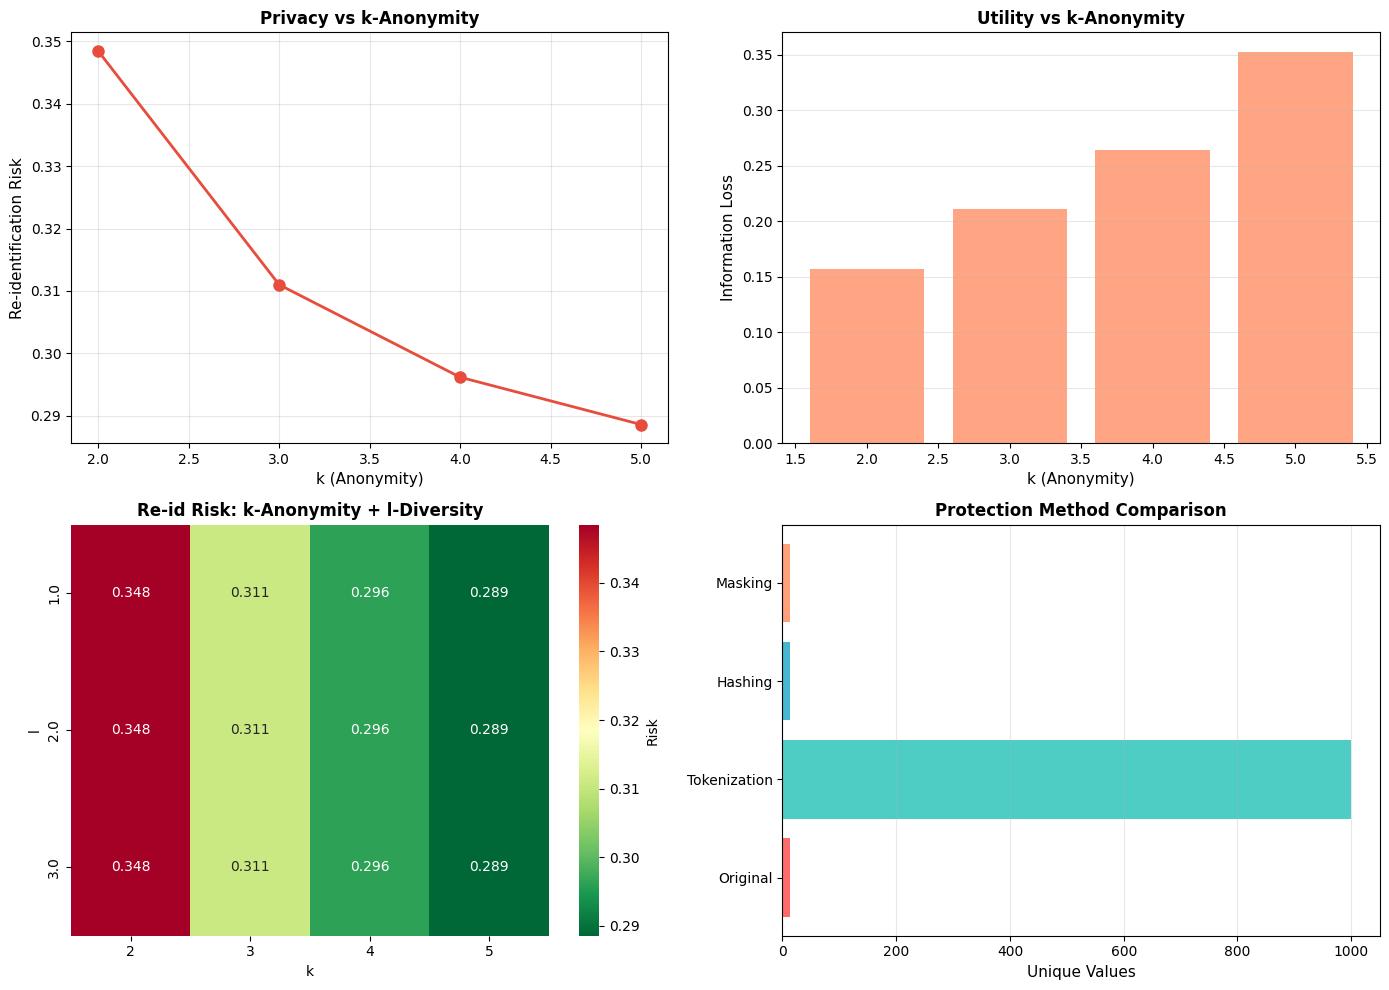

 Saved: /content/anonymized_analysis.png


In [29]:
# ===== CELL 13: Create Visualizations =====
print("Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Re-identification Risk vs k
k_only = results_df[results_df["l"].isna()]
axes[0, 0].plot(k_only["k"], k_only["reid_risk"], marker='o', linewidth=2, markersize=8, color='#E74C3C')
axes[0, 0].set_xlabel("k (Anonymity)", fontsize=11)
axes[0, 0].set_ylabel("Re-identification Risk", fontsize=11)
axes[0, 0].set_title("Privacy vs k-Anonymity", fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Plot 2: Information Loss vs k
axes[0, 1].bar(k_only["k"], k_only["info_loss"], color='coral', alpha=0.7)
axes[0, 1].set_xlabel("k (Anonymity)", fontsize=11)
axes[0, 1].set_ylabel("Information Loss", fontsize=11)
axes[0, 1].set_title("Utility vs k-Anonymity", fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: k-l combinations heatmap
kl_data = results_df[results_df["l"].notna()]
if not kl_data.empty:
    pivot = kl_data.pivot(index="l", columns="k", values="reid_risk")
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="RdYlGn_r", ax=axes[1, 0], cbar_kws={'label': 'Risk'})
    axes[1, 0].set_title("Re-id Risk: k-Anonymity + l-Diversity", fontsize=12, fontweight='bold')
else:
    axes[1, 0].text(0.5, 0.5, 'No l-diversity data', ha='center', va='center')
    axes[1, 0].set_title("Re-id Risk: k-Anonymity + l-Diversity", fontsize=12, fontweight='bold')

# Plot 4: Protection methods comparison
if not protection.empty:
    axes[1, 1].barh(protection["Method"], protection["Unique_Values"],
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
    axes[1, 1].set_xlabel("Unique Values", fontsize=11)
    axes[1, 1].set_title("Protection Method Comparison", fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No protection data', ha='center', va='center')
    axes[1, 1].set_title("Protection Method Comparison", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_PREFIX}_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print(f" Saved: {OUTPUT_PREFIX}_analysis.png")

Visualizing privacy risk and method metrics (optimized)...


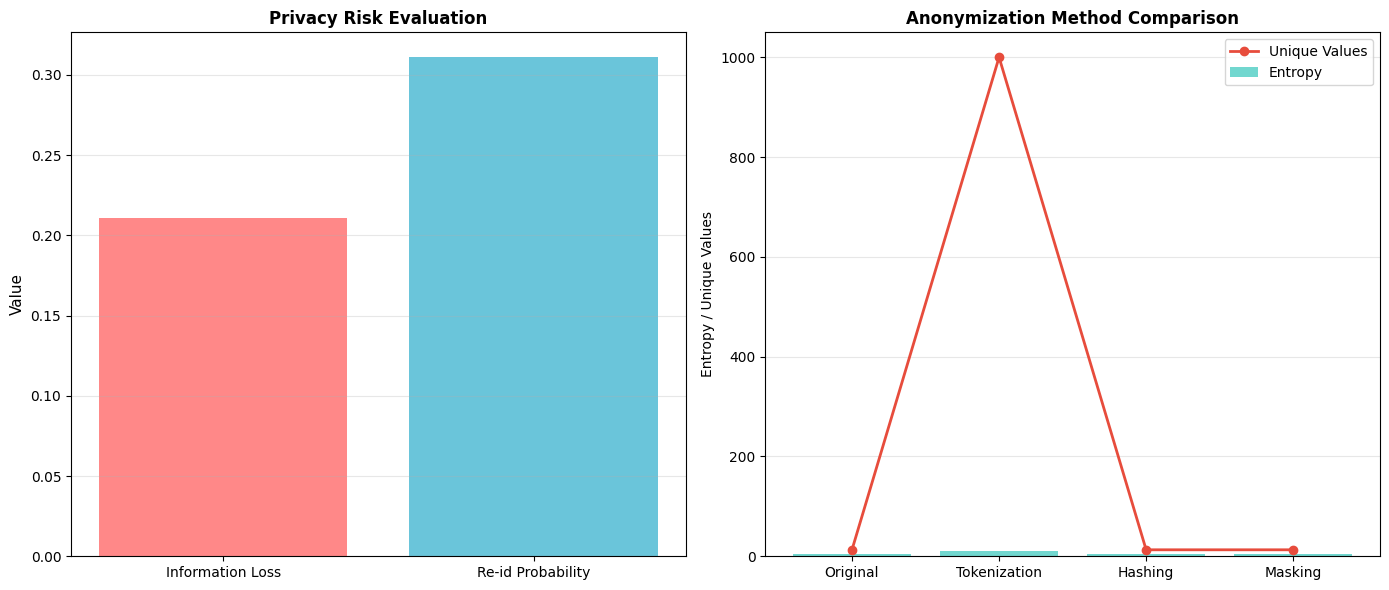

✓ Saved: /content/anonymized_privacy_visuals.png


In [35]:
# ===== OPTIMIZED CELL: Privacy Risk and Method Visualization =====
print("Visualizing privacy risk and method metrics (optimized)...")

# --- Use precomputed results (no recomputation) ---
# We'll reuse the baseline and results_df values instead of recalculating k-anonymity
try:
    # Estimate information loss and re-identification probability from k=3 results
    k3_row = results_df[(results_df["k"] == 3) & (results_df["l"].isna())].iloc[0]
    risk_eval = {
        "information_loss": k3_row["info_loss"],
        "reidentification_probability": k3_row["reid_risk"]
    }
except Exception as e:
    print("⚠ Could not retrieve k=3 metrics from results_df:", e)
    risk_eval = {"information_loss": 0, "reidentification_probability": 0}

# --- Create visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Information Loss vs Re-identification Probability
axes[0].bar(["Information Loss", "Re-id Probability"],
             [risk_eval["information_loss"], risk_eval["reidentification_probability"]],
             color=["#FF6B6B", "#45B7D1"], alpha=0.8)
axes[0].set_title("Privacy Risk Evaluation", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Value", fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Method Comparison
if not comparison_metrics.empty:
    ax2 = axes[1]
    ax2.bar(comparison_metrics["Method"], comparison_metrics["entropy"],
            color="#4ECDC4", alpha=0.8, label="Entropy")
    ax2.plot(comparison_metrics["Method"], comparison_metrics["unique_values"],
             color="#E74C3C", marker='o', linewidth=2, label="Unique Values")
    ax2.set_title("Anonymization Method Comparison", fontsize=12, fontweight='bold')
    ax2.set_ylabel("Entropy / Unique Values")
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
else:
    axes[1].text(0.5, 0.5, "No data for comparison", ha='center', va='center')

plt.tight_layout()
plt.savefig(f"{OUTPUT_PREFIX}_privacy_visuals.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_PREFIX}_privacy_visuals.png")


In [30]:
# ===== CELL 14: Fast Save All Outputs =====
print("Saving results (optimized)...")

import time
t0 = time.time()

# ---------- Helper: fast k-Anonymity ----------
def apply_k_anonymity_fast(df, qi_cols, k):
    """Vectorized suppression-based k-Anonymity (fast)."""
    df = df.copy()
    if not qi_cols:
        return df
    # Compute group sizes
    group_sizes = df.groupby(qi_cols).size()
    small_keys = group_sizes[group_sizes < k].index
    if len(small_keys) == 0:
        return df
    # Mark all rows belonging to small groups in one shot
    mask = df[qi_cols].merge(
        small_keys.to_frame(index=False), on=qi_cols, how="left", indicator=True
    )["_merge"].eq("both")
    # Suppress the highest-cardinality QI column
    card = {c: df[c].nunique(dropna=False) for c in qi_cols}
    col_to_suppress = max(card, key=card.get)
    df.loc[mask, col_to_suppress] = "*"
    return df

# ---------- Save results ----------
# Save metrics
results_df.to_csv(f"{OUTPUT_PREFIX}_metrics.csv", index=False)
print(f" Saved: {OUTPUT_PREFIX}_metrics.csv")

# Save protection comparison
if not protection.empty:
    protection.to_csv(f"{OUTPUT_PREFIX}_methods.csv", index=False)
    print(f" Saved: {OUTPUT_PREFIX}_methods.csv")

# Save anonymized dataset (k=3) using the fast version
final_anon = apply_k_anonymity_fast(work_df, qi_mapped, 3)
final_anon.to_csv(f"{OUTPUT_PREFIX}_data_k3.csv", index=False)
print(f" Saved: {OUTPUT_PREFIX}_data_k3.csv")

print(f"\n All outputs saved successfully in {time.time()-t0:.2f} seconds")


Saving results (optimized)...
 Saved: /content/anonymized_metrics.csv
 Saved: /content/anonymized_methods.csv
 Saved: /content/anonymized_data_k3.csv

 All outputs saved successfully in 0.02 seconds


In [31]:
# ===== CELL 15: Display Summary =====
print("\n" + "="*60)
print("ANONYMIZATION SUMMARY")
print("="*60)
print(f"Original records: {len(df)}")
print(f"Baseline distinct QI combinations: {baseline['distinct_combinations']}")
print(f"Baseline re-identification risk: {baseline['avg_reidentification_risk']:.4f}")

print("\n TOP 5 CONFIGURATIONS (by lowest risk):")
top5 = results_df.nsmallest(5, 'reid_risk')
for idx, row in top5.iterrows():
    l_val = f"l={int(row['l'])}" if pd.notna(row['l']) else "l=None"
    print(f"  • k={int(row['k'])}, {l_val}: Risk={row['reid_risk']:.4f}, Info Loss={row['info_loss']:.2%}")

print("\n BEST CONFIGURATION (lowest risk):")
best = results_df.loc[results_df["reid_risk"].idxmin()]
l_display = f"l={int(best['l'])}" if pd.notna(best['l']) else "no l-diversity"
print(f"  k={int(best['k'])}, {l_display}")
print(f"  Re-identification Risk: {best['reid_risk']:.4f}")
print(f"  Information Loss: {best['info_loss']:.2%}")
print("="*60)


ANONYMIZATION SUMMARY
Original records: 1000
Baseline distinct QI combinations: 261
Baseline re-identification risk: 0.5091

 TOP 5 CONFIGURATIONS (by lowest risk):
  • k=5, l=None: Risk=0.2886, Info Loss=35.25%
  • k=5, l=1: Risk=0.2886, Info Loss=35.25%
  • k=5, l=2: Risk=0.2886, Info Loss=35.25%
  • k=5, l=3: Risk=0.2886, Info Loss=35.25%
  • k=4, l=None: Risk=0.2962, Info Loss=26.44%

 BEST CONFIGURATION (lowest risk):
  k=5, no l-diversity
  Re-identification Risk: 0.2886
  Information Loss: 35.25%


In [36]:
print("\nADDITIONAL PRIVACY EVALUATION SUMMARY")
print("-" * 60)
print(f"Information Loss: {risk_eval['information_loss']:.2%}")
print(f"Re-identification Probability: {risk_eval['reidentification_probability']:.4f}")
print("-" * 60)



ADDITIONAL PRIVACY EVALUATION SUMMARY
------------------------------------------------------------
Information Loss: 21.07%
Re-identification Probability: 0.3110
------------------------------------------------------------
